In [81]:
from tensorflow.keras.datasets import mnist
import numpy as np
import math
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [82]:
class ANN:
  def __init__(self, n_epoch, learning_rate, batch_size, n_input, n_h1, n_h2, n_output):
    self.learning_rate = learning_rate,
    self.n_epoch = n_epoch
    self.batch_size = batch_size
    self.n_input = n_input

    # Xavier weight initialization
    self.w1 = np.random.randn(n_h1, n_input) * np.sqrt(1. / (n_h1 + n_input))
    self.w2 = np.random.randn(n_h2, n_h1) * np.sqrt(1. / (n_h2 + n_h1))
    self.w3 = np.random.randn(n_output, n_h2) * np.sqrt(1. / (n_output + n_h2))

      
    # store a_i (activation) and z_i (W_i * a_(i-1)) parameter values
    self.x = np.zeros((n_input, batch_size))
    self.a1 = np.zeros((n_h1, batch_size))
    self.a2 = np.zeros((n_h2, batch_size))
    self.a3 = np.zeros((n_output, batch_size))
    self.z1 = np.zeros((n_h1, batch_size))
    self.z2 = np.zeros((n_h2, batch_size))
    self.z3 = np.zeros((n_output, batch_size))
    
    # store partial derivatives wrt w1,w2,w3
    self.partials = dict()

  def softmax(self, x, derivative=False):
    if derivative:
      return self.softmax(x) * (1. - self.softmax(x))
    x -= np.max(x, axis=1, keepdims=True) # ensure numerical stability by subtracting max value of each row
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

  def sigmoid(self, x, derivative=False):
    if derivative:
      return self.sigmoid(x) * (1. - self.sigmoid(x))
    return 1. / (1. + np.exp(-x))

  def forward_pass(self, x):
    self.x = x
    self.z1 = np.dot(self.w1,x)
    self.a1 = self.sigmoid(self.z1)
    self.z2 = np.dot(self.w2,self.a1)
    self.a2 = self.sigmoid(self.z2)
    self.z3 = np.dot(self.w3,self.a2)
    self.a3 = self.softmax(self.z3)

  def compute_gradients(self, y_true):
    """
    Backpropagation

    note: y_true has shape (n_batch x 10)
    """
    partials = dict()

    # calculate partil derivatives wrt w_i
    dLoss_dz3 = - np.sum(y_true*(1./self.a3),axis=1).reshape((10, 1)) * self.softmax(self.z3, derivative=True)
    partials['dLoss_dw3'] = np.dot(dLoss_dz3, self.a2.T)
    dLoss_dz2 = np.dot(dLoss_dz3.T, self.w3).T * self.sigmoid(self.z2, derivative=True)
    partials['dLoss_dw2'] = np.dot(dLoss_dz2, self.a1.T)
    dLoss_dz1 = np.dot(dLoss_dz2.T, self.w2).T * self.sigmoid(self.z1, derivative=True)
    partials['dLoss_dw1'] = np.dot(dLoss_dz1, self.x.T)

    # store partial derivatives in class constructor object
    self.partials = partials

  def update_weights(self):
    self.w1 = self.w1 - (self.learning_rate * self.partials['dLoss_dw1'])
    self.w2 = self.w2 - (self.learning_rate * self.partials['dLoss_dw2'])
    self.w3 = self.w3 - (self.learning_rate * self.partials['dLoss_dw3'])

  def train(self, X_train, y_train, y_train_orig, X_test, y_test_orig):
    test_error = []
    train_error = []
    for epoch in range(self.n_epoch):
      X_train_minibatches = []
      y_train_minibatches = []
      A = np.concatenate((X_train.T, y_train.T),axis=1)
      np.random.shuffle(A)
      X_train, y_train = A[:,0:784].T, A[:,784:].T
      n_batch = math.floor(X_train.shape[1] / self.batch_size)
      indx = 0
      for i in range(n_batch):
        X_train_minibatches.append(X_train.T[indx:indx+self.batch_size+1].T)
        y_train_minibatches.append(y_train.T[indx:indx+self.batch_size+1].T)
        indx += self.batch_size
      for j in range(len(X_train_minibatches)):
        self.forward_pass(X_train_minibatches[j])
        self.compute_gradients(y_train_minibatches[j])
        self.update_weights()
      test_error.append(1 - accuracy_score(y_test_orig,self.predict(X_test)[1]))
      train_error.append(1 - accuracy_score(y_train_orig,self.predict(X_train)[1]))
      print(f"Epoch {epoch + 1} Test Error: {test_error[-1]}")
    # plot learning curve 
    epochs = np.arange(1, self.n_epoch+1, step=1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_error, label='Train Error')
    plt.plot(epochs, test_error, label='Test Error')
    plt.xlabel("Number of Epochs")
    plt.ylabel("Error Rate")
    plt.legend(loc='upper right')
    plt.xticks(epochs)
    plt.yticks(np.arange(0, 1.1, step=.1))

  def predict(self, X_test):
    a3_pred = self.softmax(np.dot(self.w3,self.sigmoid(np.dot(self.w2,self.sigmoid(np.dot(self.w1,X_test)))))).T # n_sample x 10
    return (a3_pred,np.argmax(a3_pred, axis=1))

  def get_partials(self):
    return self.partials

In [74]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('X_train: ' + str(X_train.shape))
print('y_train: ' + str(y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('y_test:  '  + str(y_test.shape))

X_train: (60000, 28, 28)
y_train: (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In [77]:
# reshape and normalize X_train
X_trian_norm = np.zeros((60000,784))
for i in range(0, 60000):
  X_trian_norm[i] = X_train[i].flatten() +0.01
#X_train_norm = X_trian_norm / np.linalg.norm(X_trian_norm)
X_train_norm = (X_trian_norm  / 255.0 * 0.99) + 0.01

# reshape and normalize X_test
X_test_norm = np.zeros((10000,784))
for i in range(0, 10000):
  X_test_norm[i] = X_test[i].flatten() +0.01
#X_test_norm = X_test_norm / np.linalg.norm(X_test_norm)
X_test_norm = (X_test_norm  / 255.0 * 0.99) + 0.01

# reshape y_train as one-hot matrix with 10 columns
y_train_new = np.zeros((60000,10))
for i in range(0,60000):
  y_train_new[i,y_train_orig[i]] = 1

# reshape y_test as one-hot matrix with 10 columns
y_test_new = np.zeros((10000,10))
for i in range(0,10000):
  y_test_new[i,y_test[i]] = 1

Epoch 1 Test Error: 0.9263
Epoch 2 Test Error: 0.9525
Epoch 3 Test Error: 0.9456
Epoch 4 Test Error: 0.9386
Epoch 5 Test Error: 0.9304
Epoch 6 Test Error: 0.9441
Epoch 7 Test Error: 0.9406
Epoch 8 Test Error: 0.9321
Epoch 9 Test Error: 0.9354
Epoch 10 Test Error: 0.9389
Epoch 11 Test Error: 0.9349
Epoch 12 Test Error: 0.8949
Epoch 13 Test Error: 0.9424
Epoch 14 Test Error: 0.9138
Epoch 15 Test Error: 0.9412
Epoch 16 Test Error: 0.9017
Epoch 17 Test Error: 0.9184
Epoch 18 Test Error: 0.9163
Epoch 19 Test Error: 0.8955
Epoch 20 Test Error: 0.9429


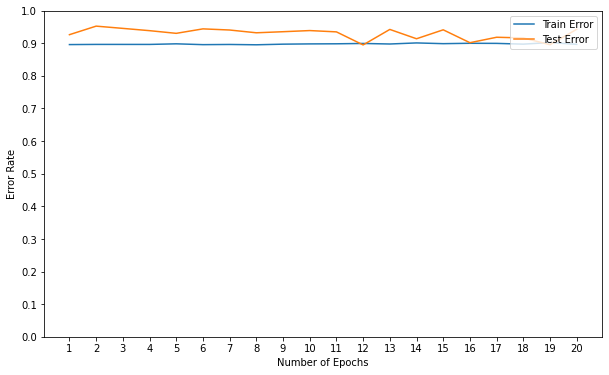

In [85]:
nn = ANN(n_epoch=20, learning_rate=.05, batch_size=32, n_input=784, n_h1=300, n_h2=200, n_output=10)
nn.train(X_train_norm.T, y_train_new.T, y_train, X_test_norm.T, y_test)